In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 19:34:04.319616: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 19:34:05.139120: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 19:34:05.186665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:34:05.186710: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:34:05.190652: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:34:05.190716: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 19:34:05.192569: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

iawe_gen_GASF_13m_100S5X4A1545_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['air conditioner', 'computer', 'fridge', 'television']
{0: 2.2888888888888888, 1: 0.8442622950819673, 2: 0.46119402985074626, 3: 4.753846153846154}
 
Tests 
air conditioner test: 34 train: 135
computer test: 92 train: 366
fridge test: 167 train: 670
television test: 16 train: 65


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/iawe/TL/iawe_12_refit, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data iawe training on model refit seed 12
reading data, printing stats: 
['air conditioner', 'computer', 'fridge', 'television']
{0: 2.2888888888888888, 1: 0.8442622950819673, 2: 0.46119402985074626, 3: 4.753846153846154}
 
Tests 
air conditioner test: 34 train: 135
computer test: 92 train: 366
fridge test: 167 train: 670
television test: 16 train: 65
loading model
compling TL model..


2022-02-11 19:34:05.769700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:34:05.770431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 19:34:05.770508: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:34:06.140623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 19:34:06.140661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 19:34:06.140668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 19:34:06.141252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 19:34:13.847594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 19:34:13.868465: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 19:34:17.293863: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 19:34:17.767650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 19:34:18.261171: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:34:18.675237: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


39/39 - 6s - loss: 0.7626 - accuracy: 0.7775
Epoch 2/50
39/39 - 1s - loss: 0.2225 - accuracy: 0.9183
Epoch 3/50
39/39 - 1s - loss: 0.1635 - accuracy: 0.9312
Epoch 4/50
39/39 - 1s - loss: 0.1652 - accuracy: 0.9231
Epoch 5/50
39/39 - 1s - loss: 0.1357 - accuracy: 0.9409
Epoch 6/50
39/39 - 1s - loss: 0.1145 - accuracy: 0.9490
Epoch 7/50
39/39 - 1s - loss: 0.1146 - accuracy: 0.9401
Epoch 8/50
39/39 - 1s - loss: 0.1037 - accuracy: 0.9474
Epoch 9/50
39/39 - 1s - loss: 0.1208 - accuracy: 0.9442
Epoch 10/50
39/39 - 1s - loss: 0.1288 - accuracy: 0.9353
Epoch 11/50
39/39 - 1s - loss: 0.1066 - accuracy: 0.9466
Epoch 12/50
39/39 - 1s - loss: 0.1147 - accuracy: 0.9515
Epoch 13/50
39/39 - 1s - loss: 0.0871 - accuracy: 0.9555
Epoch 14/50
39/39 - 1s - loss: 0.1031 - accuracy: 0.9531
Epoch 15/50
39/39 - 1s - loss: 0.0843 - accuracy: 0.9579
Epoch 16/50
39/39 - 1s - loss: 0.0861 - accuracy: 0.9595
Epoch 17/50
39/39 - 1s - loss: 0.0833 - accuracy: 0.9498
Epoch 18/50
39/39 - 1s - loss: 0.1076 - accuracy: 0

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 0.8276 - accuracy: 0.6456
Epoch 2/50
39/39 - 1s - loss: 0.2872 - accuracy: 0.8900
Epoch 3/50
39/39 - 1s - loss: 0.2048 - accuracy: 0.9199
Epoch 4/50
39/39 - 1s - loss: 0.1716 - accuracy: 0.9207
Epoch 5/50
39/39 - 1s - loss: 0.1654 - accuracy: 0.9417
Epoch 6/50
39/39 - 1s - loss: 0.1335 - accuracy: 0.9393
Epoch 7/50
39/39 - 1s - loss: 0.1292 - accuracy: 0.9563
Epoch 8/50
39/39 - 1s - loss: 0.1323 - accuracy: 0.9401
Epoch 9/50
39/39 - 1s - loss: 0.1149 - accuracy: 0.9531
Epoch 10/50
39/39 - 1s - loss: 0.1261 - accuracy: 0.9417
Epoch 11/50
39/39 - 1s - loss: 0.1107 - accuracy: 0.9458
Epoch 12/50
39/39 - 1s - loss: 0.1066 - accuracy: 0.9628
Epoch 13/50
39/39 - 1s - loss: 0.1054 - accuracy: 0.9555
Epoch 14/50
39/39 - 1s - loss: 0.1056 - accuracy: 0.9579
Epoch 15/50
39/39 - 1s - loss: 0.0865 - accuracy: 0.9668
Epoch 16/50
39/39 - 1s - loss: 0.0991 - accuracy: 0.9490
Epoch 17/50
39/39 - 1s - loss: 0.1027 - accuracy: 0.9523
Epoch 1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 1.0355 - accuracy: 0.6869
Epoch 2/50
39/39 - 1s - loss: 0.4375 - accuracy: 0.8803
Epoch 3/50
39/39 - 1s - loss: 0.2948 - accuracy: 0.8770
Epoch 4/50
39/39 - 1s - loss: 0.2955 - accuracy: 0.8738
Epoch 5/50
39/39 - 1s - loss: 0.2636 - accuracy: 0.8948
Epoch 6/50
39/39 - 1s - loss: 0.2636 - accuracy: 0.8875
Epoch 7/50
39/39 - 1s - loss: 0.2545 - accuracy: 0.8997
Epoch 8/50
39/39 - 1s - loss: 0.2226 - accuracy: 0.9021
Epoch 9/50
39/39 - 1s - loss: 0.2144 - accuracy: 0.9045
Epoch 10/50
39/39 - 1s - loss: 0.2087 - accuracy: 0.9029
Epoch 11/50
39/39 - 1s - loss: 0.2021 - accuracy: 0.9118
Epoch 12/50
39/39 - 1s - loss: 0.2326 - accuracy: 0.8835
Epoch 13/50
39/39 - 1s - loss: 0.2170 - accuracy: 0.9029
Epoch 14/50
39/39 - 1s - loss: 0.2011 - accuracy: 0.9013
Epoch 15/50
39/39 - 1s - loss: 0.1883 - accuracy: 0.9110
Epoch 16/50
39/39 - 1s - loss: 0.1992 - accuracy: 0.9037
Epoch 17/50
39/39 - 1s - loss: 0.2195 - accuracy: 0.8948
Epoch 1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 0.9195 - accuracy: 0.6667
Epoch 2/50
39/39 - 1s - loss: 0.3626 - accuracy: 0.8269
Epoch 3/50
39/39 - 1s - loss: 0.2672 - accuracy: 0.8835
Epoch 4/50
39/39 - 1s - loss: 0.2090 - accuracy: 0.9070
Epoch 5/50
39/39 - 1s - loss: 0.1922 - accuracy: 0.9256
Epoch 6/50
39/39 - 1s - loss: 0.1672 - accuracy: 0.9353
Epoch 7/50
39/39 - 1s - loss: 0.1583 - accuracy: 0.9304
Epoch 8/50
39/39 - 1s - loss: 0.1492 - accuracy: 0.9264
Epoch 9/50
39/39 - 1s - loss: 0.1523 - accuracy: 0.9320
Epoch 10/50
39/39 - 1s - loss: 0.1692 - accuracy: 0.9288
Epoch 11/50
39/39 - 1s - loss: 0.1285 - accuracy: 0.9401
Epoch 12/50
39/39 - 1s - loss: 0.1305 - accuracy: 0.9328
Epoch 13/50
39/39 - 1s - loss: 0.1222 - accuracy: 0.9523
Epoch 14/50
39/39 - 1s - loss: 0.1123 - accuracy: 0.9466
Epoch 15/50
39/39 - 1s - loss: 0.1162 - accuracy: 0.9458
Epoch 16/50
39/39 - 1s - loss: 0.1147 - accuracy: 0.9482
Epoch 17/50
39/39 - 1s - loss: 0.1119 - accuracy: 0.9498
Epoch 1

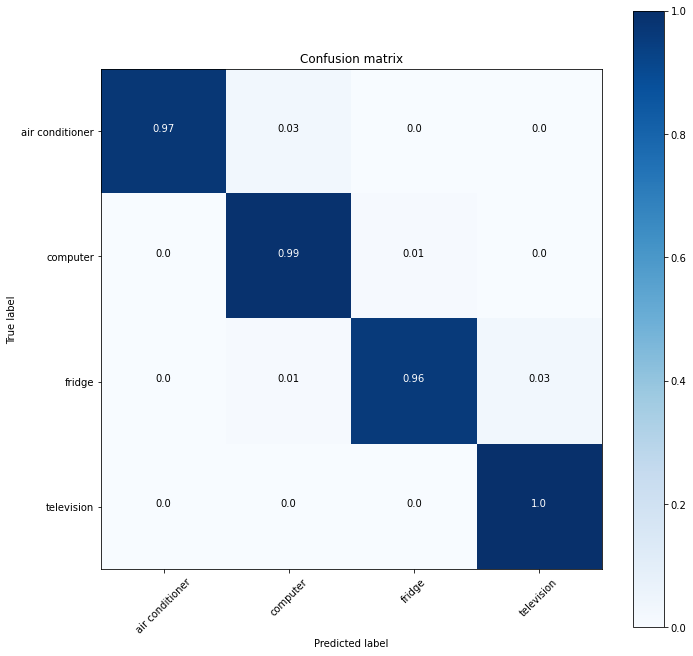

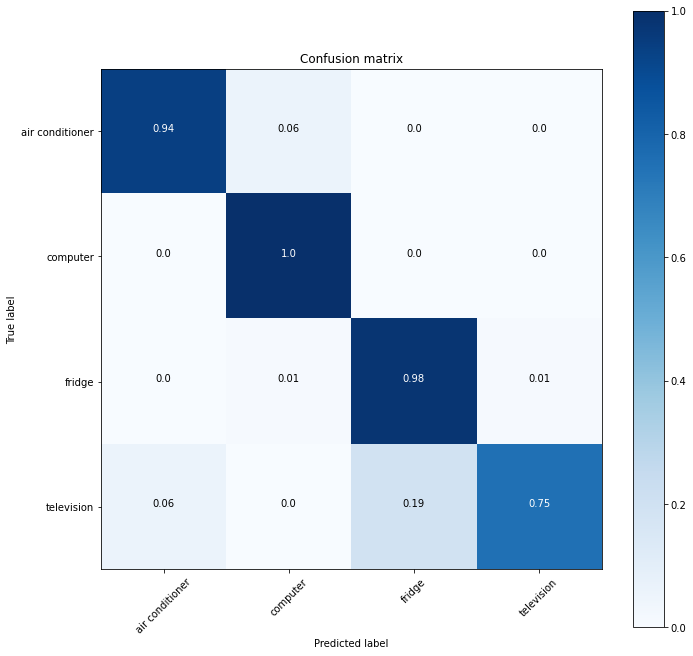

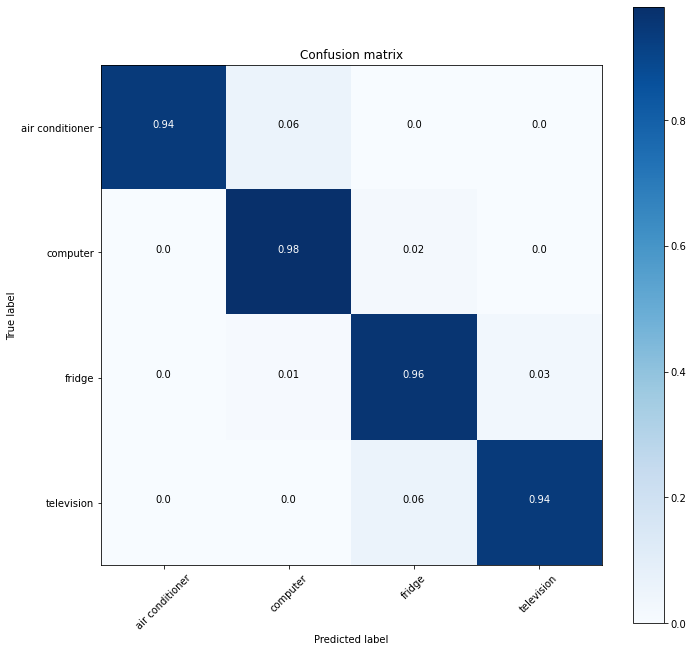

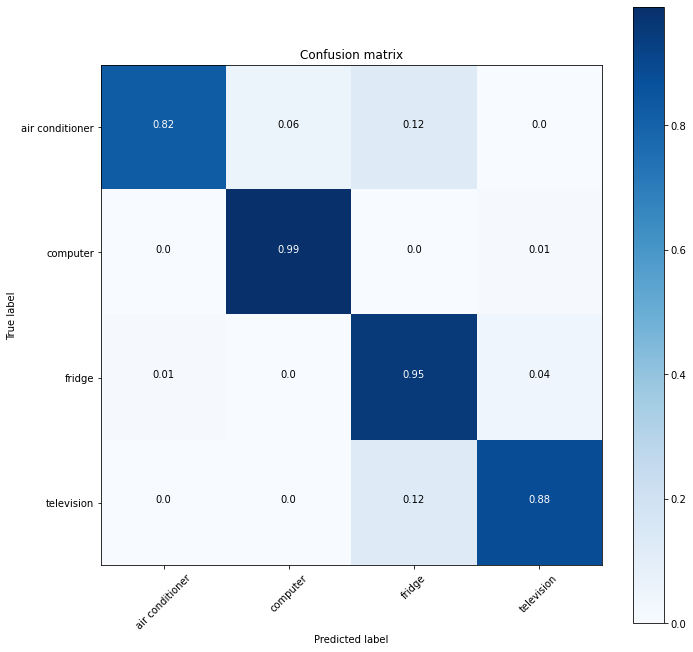

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()